In [1]:
%reload_ext autoreload

%autoreload 2
%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white')

# Insertion patterns

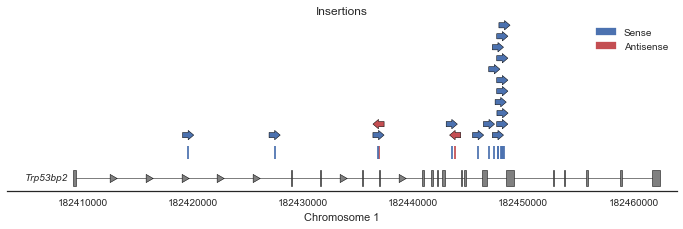

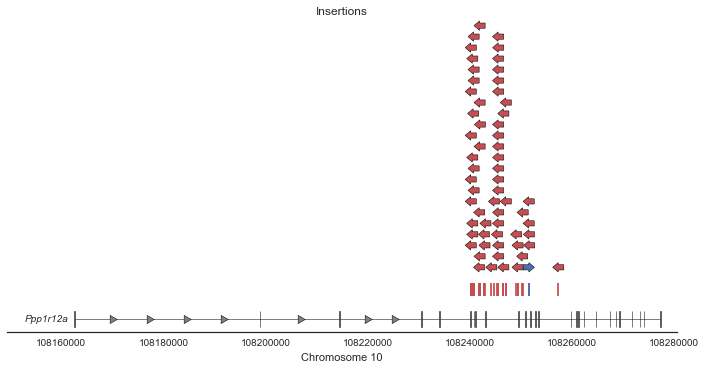

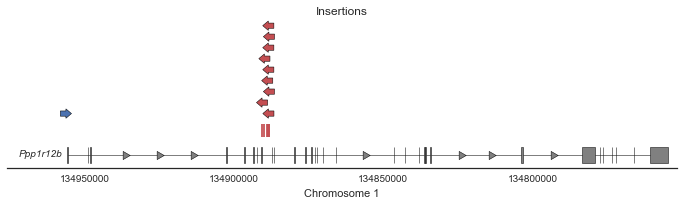

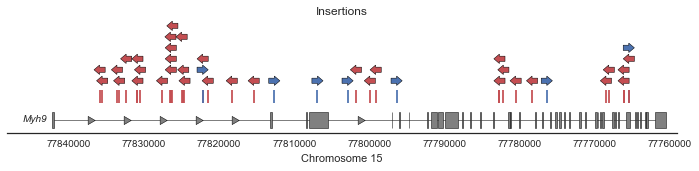

In [2]:
from collections import OrderedDict

from matplotlib import patches as mpatches
from nbsupport import insertions as nb_ins


def draw_legend(color_map, ax, title='', **kwargs):
    patches = [mpatches.Patch(color=color, label=label)
               for label, color in color_map.items()]
    return ax.legend(handles=patches, title=title, **kwargs)


# Get insertions and reference gtf file.
ins_path = ('../data/processed/shear_splink/all/insertions.cis.rbm.txt')
insertions = (pd.read_csv(ins_path, sep='\t')
                .dropna(subset=['gene_name'])
                .pipe(nb_ins.annotate_with_clonality))

gtf_path = ('/Volumes/Datastore/References/mus_musculus/mm10'
            '/gtf/Mus_musculus.GRCm38.76.gtf.gz')

# Draw transcripts.
genes = [('Trp53bp2', (6000, 1500)),
         ('Ppp1r12a', (13000, 3000)),
         ('Ppp1r12b', (20000, 3000)),
         ('Myh9', (6000, 1500))]

for i, (gene_name, padding) in enumerate(genes):
    fig = nb_ins.plot_insertion_track_gtf(
        insertions, gtf_path, gene_name=gene_name,
        padding=padding, figsize=(12, None),
        track_kws={'gene': {'label_kws': {'fontstyle': 'italic'}}})
    fig.axes[0].set_title('Insertions')
    
    if i == 0:
        color_map = OrderedDict([('Sense', sns.color_palette()[0]),
                                 ('Antisense', sns.color_palette()[2])])
        draw_legend(color_map, ax=fig.axes[0])

In [3]:
# Draw for paper.
genes = [('Trp53bp2', (6000, 1500)),
         ('Ppp1r12a', (15000, 3000)),
         ('Ppp1r12b', (25000, 3000)),
         ('Myh9', (6000, 1500))]

track_kws = {
    'gene': {
        'height': 0.12, 
        'arrow_size': 20,
        'arrow_spacing': 20,
        'plot_kws': {'lw': 0.3},
        'label_kws': {
            'fontstyle': 'italic',
            'fontsize': 6, 
         }
    },
    'insertions': {
       'height': 0.07,
       'plot_kws': {'lw': 0.3}
    },
    'rug': {
        'height': 0.1
    }
}

with sns.plotting_context('paper', font_scale=0.7):
    for i, (gene_name, padding) in enumerate(genes):
        fig = nb_ins.plot_insertion_track_gtf(
            insertions, gtf_path, gene_name=gene_name,
            padding=padding, figsize=(6, None), track_kws=track_kws, ins_size=1/150)
        fig.axes[0].set_title('Insertions')
        
        if i == 0:
            color_map = OrderedDict(
                [('Sense', sns.color_palette()[0]),
                 ('Antisense', sns.color_palette()[2])])
            legend = draw_legend(color_map, ax=fig.axes[0],
                                 title='Orientation')
            legend.get_title().set_fontsize('6')

        fig.savefig('../reports/figures/fig_5_{}_insertions.pdf'
                    .format(gene_name), bbox_inches='tight')
        plt.close(fig)

# Exon coverage

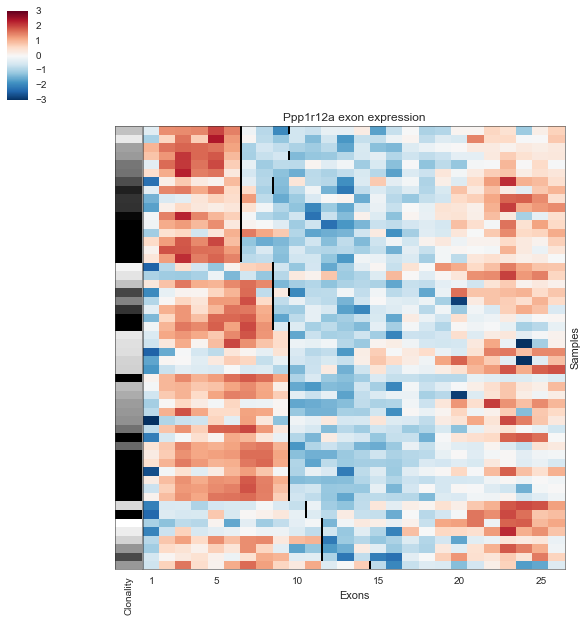

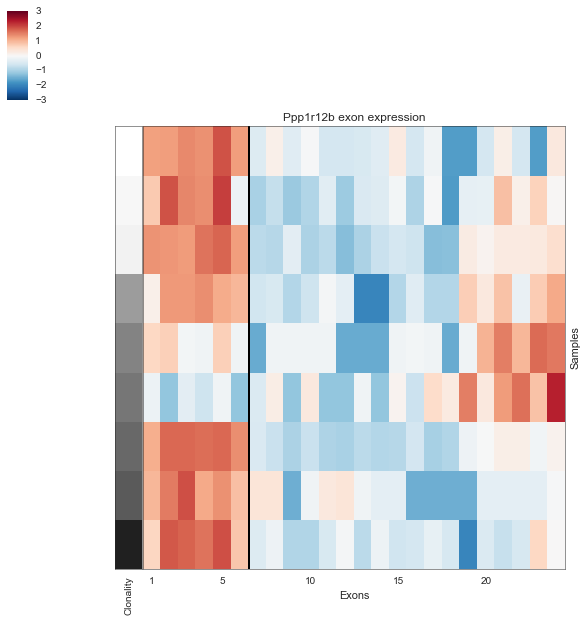

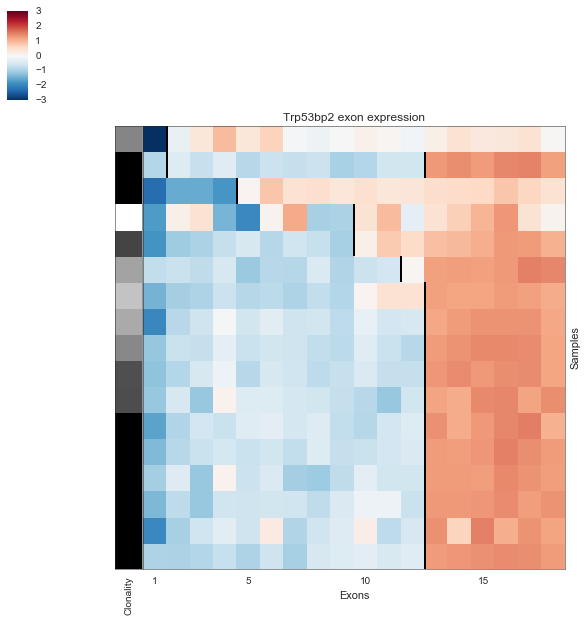

In [4]:
from nbsupport.expression import insertions as nb_expr_ins

# Ppp1r12a ENSMUSG00000019907 ENSMUST00000070663
# Ppp1r12b ENSMUSG00000073557 ENSMUST00000045665
# Trp53bp2 ENSMUSG00000026510 ENSMUST00000117245
# Myh9     ENSMUSG00000022443 ENSMUST00000016771

# Read coverage.
samples = pd.read_csv('../data/raw/samples.txt', sep='\t')
rnaseq_map = dict(zip(samples['rnaseq_id'], samples['sample']))

exon_coverage = pd.read_csv('../data/processed/expression/exon_coverage.txt', 
                            sep='\t', index_col=list(range(5)))
exon_coverage = exon_coverage.rename(columns=rnaseq_map)

# Plot.
genes = [('Ppp1r12a', 'ENSMUSG00000019907'),
         ('Ppp1r12b', 'ENSMUSG00000073557'),
         ('Trp53bp2', 'ENSMUSG00000026510')]

for gene_name, gene_id in genes:
    g = nb_expr_ins.plot_exon_expression(
        exon_coverage, gene_id=gene_id, 
        insertions=insertions, z_score=1, vmax=3, vmin=-3)
    g.ax_heatmap.set_title('{} exon expression'.format(gene_name))

In [5]:
# Draw for paper.
figsizes = {
    'Ppp1r12a': (4, 2.85),
    'Ppp1r12b': (4, 1.55),
    'Trp53bp2': (4, 1.55)
}

with sns.plotting_context('paper', font_scale=0.7):
    for gene_name, gene_id in genes:
        figsize = figsizes[gene_name]
        
        g = nb_expr_ins.plot_exon_expression(
            exon_coverage, gene_id=gene_id, insertions=insertions,
            z_score=1, vmax=3, vmin=-3, figsize=figsize)
        g.ax_heatmap.set_title('Exon expression')

        g.savefig('../reports/figures/fig_5_{}_expression.pdf'
                  .format(gene_name), bbox_inches='tight')
        
        plt.close(g.fig)